# Reddit Survey Assignment

### Due: 03/07/2016

### Completed By: Jacob Metzger

In 2011, Reddit did a survey of it's users. That survey can be found on the class Git repo as RedditShortDemoSurvey-1- Cleaned.csv.
Your assignment is as follows:
1. Clean the survey data and conduct a full EDA. (25 pts)
    1. Aggregate all Countries to their Continents.
    2. Drop US States
    3. Look for and handle missing values
    4. Create indicator variables for categoricals, bin where you feel appropriate
    5. Clean bad data (e.g. the value movies is present in “Are you a dog or a cat person?”
    6. Visualize the distributions of cleaned variables
2. Use Pearson's Correlation Coefficient, determine which variables are most highly collinear, and graph the results. 
    * (hint: http://stanford.edu/~mwaskom/ software/seaborn/examples/ many_pairwise_correlations. html) (25pts)
3. Create a random forest model that predicts YOUR dependent variable based on the remaining variables.  If your dependent variable is muti-class (more than just two classes) then I'd like you to use a confusion matrix to measure model performance.  If you'd like, you may also experiment with one-vs-all AUC methods.  (50 pts)

Determining YOUR dependent variable:
* If your Last Name Begins with A-F you will predict Employment
* If your Last Name Begins with G-K Marital Status
* **If your Last Name Begins with L-P Military Service**
* If your Last Name Begins with Q-Z Income

In [377]:
from __future__ import division #for floating division
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline
np.random.seed(314) # Set for reproducibility. 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [378]:
# The following is clipped from the Random Forests == Awesome notebook in the course notes

# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [379]:
#Another function taken from the Random Forests == Awesome notebook from the course page

# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

In [380]:
redditDataset = pd.read_csv("RedditShortDemoSurvey-1-Cleaned.csv")
redditDataset.shape

(32754, 20)

In [381]:
redditDataset.head()

,Entry Id,Please indicate your gender.,Please select the category that includes your age.,What is your marital status?,What best describes your employment status?,Are you or have you ever been in military service?,Do you currently have children under the age of 18 living in your household?,What best describes your level of education?,Treated country data,(For U. S. redditors) In which state do you live?,Which one of the following ranges includes your total yearly household income before taxes?,treated subreddit data,Are you a dog or a cat person?,"If you were a cheese, what cheese would you be?",Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,1,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,United States,New York,"$150,000 or more",getmotivated,none,none,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,United States,New York,"$150,000 or more",gaming,none,none,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Female,18-24,Blank,Freelance,none,No,Some college,United States,Virginia,"Under $20,000",snackexchange,none,none,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Male,25-34,Blank,Freelance,none,No,Bachelor's degree,United States,New York,"$150,000 or more",spacedicks,none,none,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Female,25-34,Blank,Employed full time,none,No,Bachelor's degree,United States,California,"$70,000 - $99,999",aww,none,none,NaN,NaN,NaN,NaN,NaN,NaN


In [382]:
redditDataset.describe()

,Entry Id
count,32754.000000
mean,16378.561916
std,9456.272427
min,1.000000
25%,8189.250000
50%,16379.500000
75%,24567.750000
max,32756.000000


In [383]:
describe_categorical(redditDataset)

,Please indicate your gender.,Please select the category that includes your age.,What is your marital status?,What best describes your employment status?,Are you or have you ever been in military service?,Do you currently have children under the age of 18 living in your household?,What best describes your level of education?,Treated country data,(For U. S. redditors) In which state do you live?,Which one of the following ranges includes your total yearly household income before taxes?,treated subreddit data,Are you a dog or a cat person?,"If you were a cheese, what cheese would you be?",Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
count,32754,32754,32754,32754,32754,32754,32754,32754,20846,32754,28419,32752,32754,3,3,1,1,1,1
unique,3,8,7,7,3,3,8,440,52,9,1833,7,17,3,2,1,1,1,1
top,Male,18-24,Single,Employed full time,No,No,Bachelor's degree,United States,California,"Under $20,000",askreddit,I like dogs.,Other,7/13/11 15:47,public,I like cats.,Other,7/14/11 13:22,public
freq,26418,15802,10428,14814,30526,27488,11046,20967,3401,7892,2123,17149,6562,1,2,1,1,1,1


In [384]:
redditDataset.columns

Index([u'Entry Id', u'Please indicate your gender.',
       u'Please select the category that includes your age.',
       u'What is your marital status?',
       u'What best describes your employment status?',
       u'Are you or have you ever been in military service?',
       u'Do you currently have children under the age of 18 living in your household?',
       u'What best describes your level of education?',
       u'Treated country data',
       u'(For U. S. redditors) In which state do you live?',
       u'Which one of the following ranges includes your total yearly household income before taxes?',
       u'treated subreddit data', u'Are you a dog or a cat person?',
       u'If you were a cheese, what cheese would you be?', u'Unnamed: 14',
       u'Unnamed: 15', u'Unnamed: 16', u'Unnamed: 17', u'Unnamed: 18',
       u'Unnamed: 19'],
      dtype='object')

In [385]:
#Rename columns for convenience
redditDataset.columns=["ID", "Gender", "Age", "MaritalStatus", "EmploymentStatus", "Military", "LWChildren", "Education", "Country", "USState", "AnnIncome", 
                       "Subreddit", "DogCat", "Cheese", "Other1", "Other2", "Other3", "Other4", "Other5", "Other6"]

In [386]:
redditDataset.Country.value_counts().shape

(440L,)

In [387]:
def continent(country):
    country = str.lower(country).replace('.', '').strip(' :')
    if country in ["united states", "usa", "us", "unnited states", "united states of america", "united sates", "united states of",
                   "united states of america (washington, dc)", "united states :f", "united states of american",
                   "united states of america (washington dc, y u no listed?)", "california", "united states, district of columbia",
                   "united states (apparently i can't put d.c. as my state)", "united states of america (dc)", "united s", "united st",
                   "amurkia", "amerikka", "idaho", "unites states", "america", "us of a", "amurika", "u s a",
                   
                   "canada", "canada, eh", "cananda", "canada, eh?", "canadia", "toronto", "canda", "camada",
                   "mexico", "méxico", "puerto rico", "mx",
                   "barbados", "bermuda", "british virgin islands", "haiti", "dominican republic", "dominica", 
                   "belize", "sint maarten", "nicaragua", "jamaica", "trinidad & tobago", "cayman islands", "antigua and barbuda",
                   "trinidad and tobago", "stvincent", "bahamas", "aruba", "winland", "usvi"
                   ] or "united s" in country or "canada" in country:
        return "NorthAmerica"
    elif country in ["brazil", "brazilf",
                     "chile", "costa rica", "colombia", "argentina", "paraguay", "el salvador", "uruguay",
                     "venezuela", "panama", "peru", "honduras", "guatemala", "bolivia", "ecuador", "brasil",
                     "sv", "suriname", "guyana"
                    ]:
        return "SouthAmerica"
    elif country in ["japan", "china", "israel", "india", "kuwait", "united arab emirates", "malaysia", "pakistan", "indonesia",
                     "korea, south", "south korea", "thailand", "singapore", "brunei", "hong", "hong kong", "taiwan", "phillippines",
                     "philippines", "jordan", "republic of korea", "cambodia", "saudi arabia", "oman", "qatar", "lebanon",
                     "united arab emarites", "mongolia", "palestine","vietnam", "singapore!", "nepal", "bangladesh", "bahrain",
                     "sri lanka", "indiia", "iran", "iraq, kurdistan", "brunei darussalem", "maldives", "phiilippines",
                     "myanmar", "kingdom of saudi arabia"
                    ] \
        or "kong" in country \
        or "china" in country \
        or "korea" in country:
            return "Asia"
    elif country in ["united kingdom", "finland", "germany", "romania", "france", "norway", "republic of ireland", "ireland",
                    "greece", "sweden", "switzerland", "netherlands", "the netherlands", "spain", "belgium", "poland",
                     "bulgaria", "italy", "denmark", "bosnia and herzegovina", "slovenia", "iceland", "croatia", "scotland",
                     "england", "portugal", "slovakia", "estonia", "malta", "swedeb", "united kingdon", "wales",
                     "peoples republic of south yorkshire", "northern ireland", "czech republic", "united kingdom (england)",
                     "austria", "ukraine", "russia", "lithuania", "hungary", "england, united kingdom", "macedonia", 
                     "holland", "federal republic of germany", "united kingdom of great britain and northern ireland", 
                     "luxembourg", "turkey", "unitd kingdom", "greenland", "united kingdom of great britain", "serbia",
                     "swiss", "united kingdom (scotland)", "uk", "united knigdom", "uninted kingdom", "gibraltar", "united jingdom",
                     "u.k", "united kingdom, india", "republic of poland", "united  kingdom", "isle of man", "swedem", "swden", "ger",
                     "latvia", "frabce", "afghanistan", "eire", "cyprus", "holy see", "dk", "uk lol", "grand duchy of baden", 
                     "united kingdown", "uk problem?", "the czech republic", "untied kingdom", "united kindom", "montenegro",
                     "belarus", "albania", "faroe islands", "frande", "kosovo", "kosova", "andorra", "great britian", "united kingdo,",
                     "slovak republic", "catalonia", "belgrium", "united kingom", "helsinki", "unted kingdom", "italy it",
                     "croatua", "scotland and sweden", "algeria", "netehrlands", "nether", "galiza", "bg", "itaky"
                    ] \
        or "united kingdom" in country \
        or "ireland" in country \
        or "poland" in country \
        or "russian" in country \
        or "moldova" in country \
        or "basque" in country \
        or "britain" in country \
        or "macedonia" in country \
        or "norway" in country \
        or "netherlands" in country \
        or "bosnia" in country:
            return "Europe"
    elif country in ["australia", "australi", "ozstralia", "guam", "republic of the marshall islands",
                     "new zealand", "fiji", "new zealanad", "austrailia", "austraila", "newzealand",
                     "papua new guinea", "commonwealth of the northern mariana islands"
                    ]:
        return "Oceania"
    elif country in ["kenya", "south africa", "egypt", "uganda", "tunisia", "cameroon", "equestria", "tanzania",
                    "zimbabwe", "morocco", "mauritius", "nigeria", "guinea-bissau", "zambia"
                    ]:
        return "Africa"
    elif country in ["none", "n", "country", "united", "/", "vou0302833", "equestria", "epson printer", "random", "antarctica",
                     "people", "ubit", "funland", 
                    ] \
        or country.startswith("i planned") \
        or "http" in country or country.startswith("peter")\
        or "travel" in country \
        or "vagabond" in country:
            return "Invalid"
    else:
        print country
        return "Invalid" ###Tentative for now... finish cleaning this
###THERE SHOULD BE NO PRINTED OUTPUT!
redditDataset.Country = redditDataset.Country.apply(continent)

In [388]:
redditDataset.drop(["USState"], axis=1, inplace=True)

In [389]:
describe_categorical(redditDataset)

,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese,Other1,Other2,Other3,Other4,Other5,Other6
count,32754,32754,32754,32754,32754,32754,32754,32754,32754,28419,32752,32754,3,3,1,1,1,1
unique,3,8,7,7,3,3,8,7,9,1833,7,17,3,2,1,1,1,1
top,Male,18-24,Single,Employed full time,No,No,Bachelor's degree,NorthAmerica,"Under $20,000",askreddit,I like dogs.,Other,7/13/11 15:47,public,I like cats.,Other,7/14/11 13:22,public
freq,26418,15802,10428,14814,30526,27488,11046,24319,7892,2123,17149,6562,1,2,1,1,1,1


In [390]:
redditDataset.Other1 = redditDataset.Other1.fillna(0)
redditDataset.Other2 = redditDataset.Other2.fillna(0)
redditDataset.Other3 = redditDataset.Other3.fillna(0)
redditDataset.Other4 = redditDataset.Other4.fillna(0)
redditDataset.Other5 = redditDataset.Other5.fillna(0)
redditDataset.Other6 = redditDataset.Other6.fillna(0)

redditDataset[(redditDataset.Other1>1) | 
              (redditDataset.Other2>1) |
              (redditDataset.Other3>1) |
              (redditDataset.Other4>1) | 
              (redditDataset.Other5>1) |
              (redditDataset.Other6>1)
             ]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese,Other1,Other2,Other3,Other4,Other5,Other6
2705,2706,Male,18-24,Single,"Not employed, but looking for work",No,No,Bachelor's degree,Europe,none,DROP TABLE `users`,NaN,1,7/13/11 15:47,public,0,0,0,0
30331,30334,Male,25-34,In a relationship,Employed full time,No,No,Bachelor's degree,NorthAmerica,"$70,000 - $99,999",DROP TABLE USERS,NaN,programming'),7/14/11 12:12,public,0,0,0,0
30857,30860,Male,25-34,Forever Alone,Employed full time,No,No,Some college,NorthAmerica,"$40,000 - $49,999",Hip Hop,Reddit.com,Pics,pics,,I like cats.,Other,7/14/11 13:22,public


These lines look like a waste, between what looks like a bad attempt at a SQL injection and gibberish. We can just drop this, and drop the six unnecessary columns.

In [391]:
redditDataset = redditDataset.drop([2705, 30331, 30857])


In [392]:
redditDataset = redditDataset.drop(["Other1", "Other2","Other3","Other4","Other5","Other6"], axis=1)

In [393]:
describe_categorical(redditDataset)

,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
count,32751,32751,32751,32751,32751,32751,32751,32751,32751,28416,32751,32751
unique,3,8,7,7,3,3,8,7,9,1830,6,14
top,Male,18-24,Single,Employed full time,No,No,Bachelor's degree,NorthAmerica,"Under $20,000",askreddit,I like dogs.,Other
freq,26415,15801,10427,14812,30523,27485,11044,24317,7892,2123,17149,6562


### Graphs

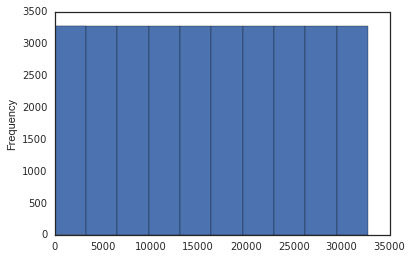

In [394]:
redditDataset.ID.plot(kind='hist')

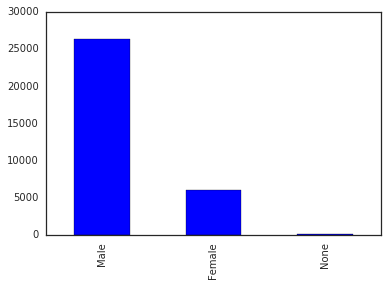

In [395]:
redditDataset.Gender.value_counts().plot(kind='bar')

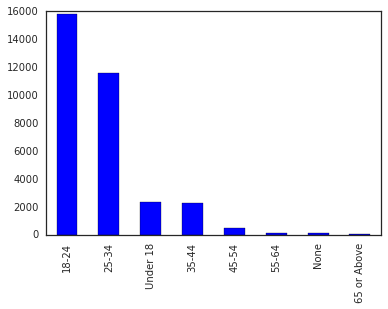

In [396]:
redditDataset.Age.value_counts().plot(kind="bar")

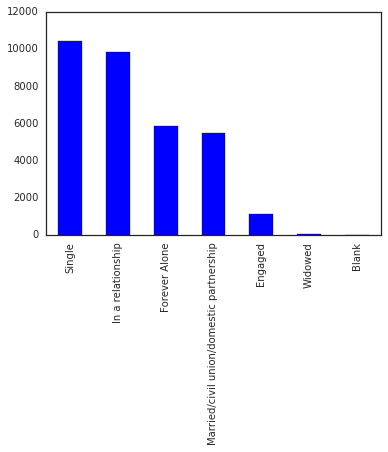

In [397]:
redditDataset.MaritalStatus.value_counts().plot(kind="bar")

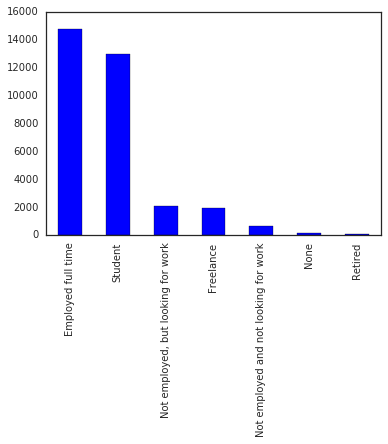

In [398]:
redditDataset.EmploymentStatus.value_counts().plot(kind="bar")

No      30523
Yes      2223
none        5
Name: Military, dtype: int64


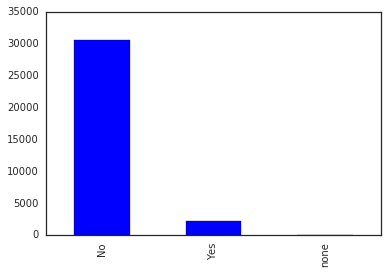

In [399]:
redditDataset.Military.value_counts().plot(kind="bar")
print redditDataset.Military.value_counts()

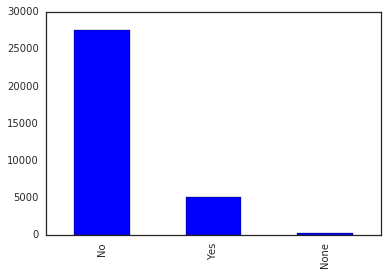

In [400]:
redditDataset.LWChildren.value_counts().plot(kind="bar")

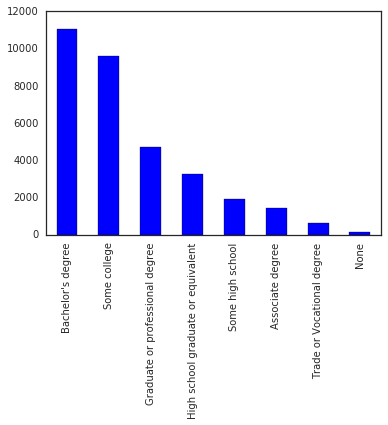

In [401]:
redditDataset.Education.value_counts().plot(kind="bar")

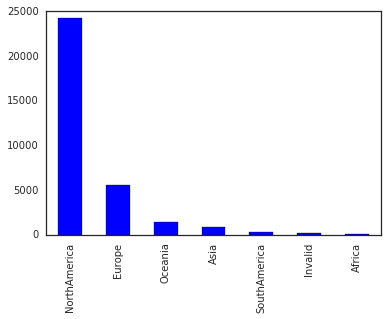

In [402]:
redditDataset.Country.value_counts().plot(kind="bar")

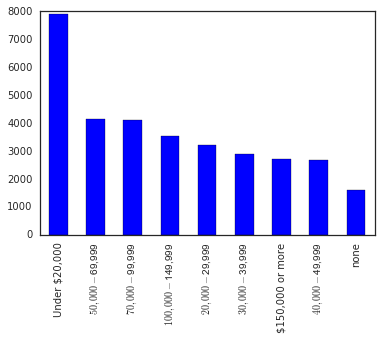

In [403]:
redditDataset.AnnIncome.value_counts().plot(kind="bar")

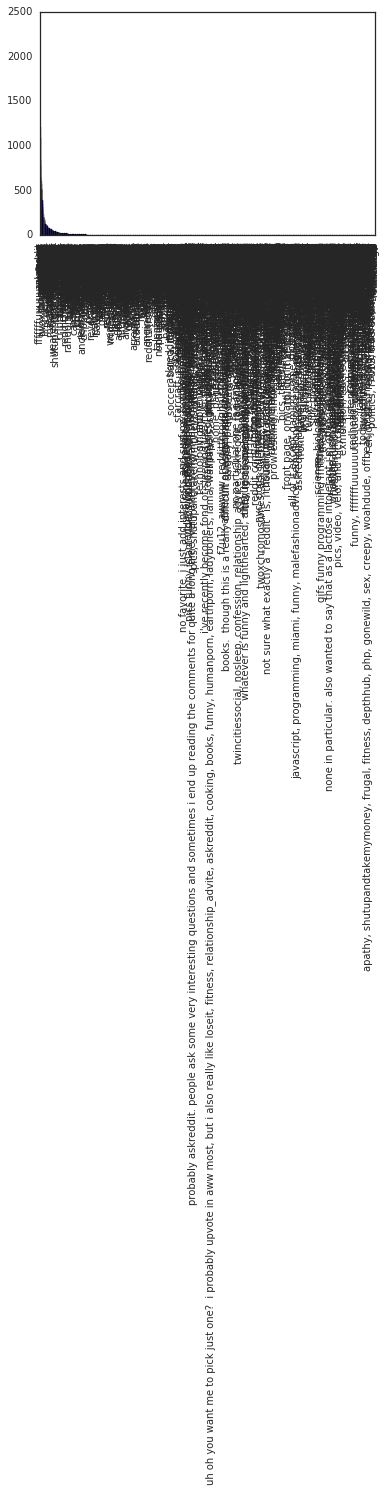

In [404]:
redditDataset.Subreddit.value_counts().plot(kind="bar")

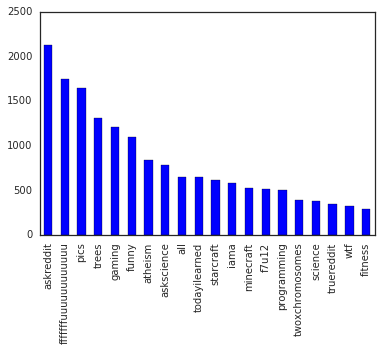

In [405]:
redditDataset.Subreddit.value_counts()[0:20].plot(kind="bar") #Just get some top results, since this is a messy variable.

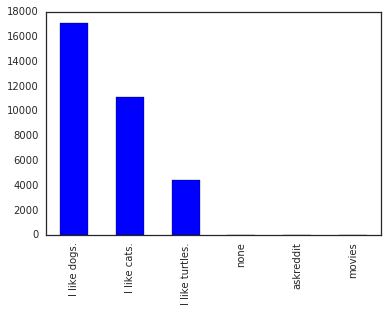

In [406]:
redditDataset.DogCat.value_counts().plot(kind="bar")

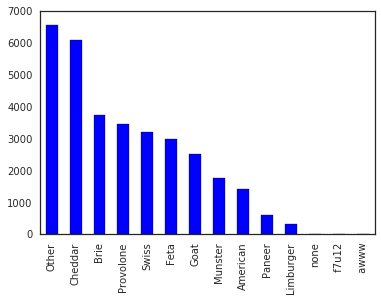

In [407]:
redditDataset.Cheese.value_counts().plot(kind="bar")

### More Exploring

In [408]:
#Age

redditDataset[redditDataset.Age=="None"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
675,676,None,None,Forever Alone,None,Yes,None,None,NorthAmerica,none,NaN,I like dogs.,Cheddar
752,753,None,None,Forever Alone,Employed full time,Yes,No,Graduate or professional degree,NorthAmerica,"$100,000 - $149,999",gaming,I like cats.,American
1565,1566,None,None,Forever Alone,None,Yes,None,None,Invalid,"$70,000 - $99,999","tf2, ireland",I like dogs.,Goat
1913,1914,Male,None,Forever Alone,"Not employed, but looking for work",No,No,High school graduate or equivalent,Europe,"$20,000 - $29,999",gaming,I like cats.,Other
1949,1950,None,None,Forever Alone,None,Yes,None,Bachelor's degree,Europe,"Under $20,000",radiohead,I like dogs.,Brie
2081,2082,Male,None,Single,"Not employed, but looking for work",No,No,Bachelor's degree,NorthAmerica,"Under $20,000",asoiaf,I like dogs.,Feta
3114,3115,Female,None,Single,Freelance,No,No,Bachelor's degree,NorthAmerica,"Under $20,000",fffffffuuuuuuuuuuuu,I like dogs.,Feta
3362,3363,None,None,Forever Alone,None,Yes,None,None,Invalid,none,NaN,I like dogs.,American
3903,3904,None,None,Forever Alone,None,Yes,None,None,Invalid,none,NaN,I like dogs.,Cheddar
4172,4173,Male,None,Single,Student,No,No,Some college,NorthAmerica,none,wtf,I like turtles.,Cheddar


It looks like we'll have to impute these, and we may have some luck based on the Relationship and Education columns. Interestingly, 1565 has a nice annual income but no employment status...

In [409]:
redditDataset.Age = redditDataset.Age.replace("None", redditDataset.Age.mode()) #impute age with Mode, for now

In [410]:
#Marital Status

redditDataset[redditDataset.MaritalStatus=="Blank"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
0,1,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",getmotivated,none,none
1,2,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",gaming,none,none
2,3,Female,18-24,Blank,Freelance,none,No,Some college,NorthAmerica,"Under $20,000",snackexchange,none,none
3,4,Male,25-34,Blank,Freelance,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",spacedicks,none,none
4,5,Female,25-34,Blank,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$70,000 - $99,999",aww,none,none


Let's just impute this with the mode...

In [411]:
redditDataset.MaritalStatus = redditDataset.MaritalStatus.replace("Blank", redditDataset.MaritalStatus.mode())

In [412]:
#Employment Status

redditDataset[redditDataset.EmploymentStatus=="None"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
150,151,Male,Under 18,Single,None,No,Yes,High school graduate or equivalent,NorthAmerica,"$50,000 - $69,999",starcraft,I like dogs.,Provolone
393,394,Male,25-34,Single,None,No,No,High school graduate or equivalent,NorthAmerica,"$20,000 - $29,999",NaN,I like cats.,Cheddar
435,436,Male,25-34,Engaged,None,No,No,Graduate or professional degree,NorthAmerica,"$40,000 - $49,999",gaming,I like dogs.,American
663,664,Female,18-24,Single,None,Yes,No,Some college,NorthAmerica,"$150,000 or more",scifi,I like cats.,Brie
675,676,None,None,Forever Alone,None,Yes,None,None,NorthAmerica,none,NaN,I like dogs.,Cheddar
931,932,Male,18-24,In a relationship,None,No,Yes,Some college,NorthAmerica,"Under $20,000",f7u12,I like dogs.,American
1565,1566,None,None,Forever Alone,None,Yes,None,None,Invalid,"$70,000 - $99,999","tf2, ireland",I like dogs.,Goat
1934,1935,Female,18-24,In a relationship,None,No,No,Bachelor's degree,NorthAmerica,"Under $20,000",pittsburgh,I like turtles.,Other
1949,1950,None,None,Forever Alone,None,Yes,None,Bachelor's degree,Europe,"Under $20,000",radiohead,I like dogs.,Brie
2062,2063,Male,Under 18,Forever Alone,None,No,No,Bachelor's degree,Europe,"$70,000 - $99,999",jailbait,I like cats.,Feta


A sizeable number of these with no employment status have decent incomes, which is fairly unlikely. These will need to be imputed.

In [413]:
def handleEmployment(x):
    if(x[0]=="None") and (x[1]!="Under $20,000" and x[1]!="none"):
        return "Freelance"
    else:
        return x[0]

redditDataset.EmploymentStatus = map(handleEmployment, zip(redditDataset.EmploymentStatus, redditDataset.AnnIncome))
#Observation: Imputing this variable doesn't seem to affect the ROC very much. Another reasonable guess would be to impute this
#"Employed full time", but this yields similar results. The ROC actually was a bit better without imputing this variable, but
#not appreciably.

In [414]:
#Military

redditDataset[redditDataset.Military=="none"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
0,1,Male,25-34,Single,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",getmotivated,none,none
1,2,Male,25-34,Blank,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",gaming,none,none
2,3,Female,18-24,Blank,Freelance,none,No,Some college,NorthAmerica,"Under $20,000",snackexchange,none,none
3,4,Male,25-34,Blank,Freelance,none,No,Bachelor's degree,NorthAmerica,"$150,000 or more",spacedicks,none,none
4,5,Female,25-34,Blank,Employed full time,none,No,Bachelor's degree,NorthAmerica,"$70,000 - $99,999",aww,none,none


These will just need to be imputed to "No" for military status.

In [415]:
redditDataset.Military = redditDataset.Military.replace("none", "No")

In [416]:
#LWChildren

redditDataset[redditDataset.LWChildren=="None"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
318,319,Male,35-44,In a relationship,Employed full time,Yes,None,Some college,NorthAmerica,"$50,000 - $69,999",NaN,I like cats.,Goat
552,553,Male,18-24,Single,Student,No,None,Bachelor's degree,NorthAmerica,"$70,000 - $99,999",fffffffuuuuuuuuuuuu,I like dogs.,American
675,676,None,None,Forever Alone,None,Yes,None,None,NorthAmerica,none,NaN,I like dogs.,Cheddar
1043,1044,Male,18-24,In a relationship,Student,No,None,Some college,NorthAmerica,"Under $20,000",rowing,I like cats.,Cheddar
1145,1146,Male,Under 18,In a relationship,Student,No,None,Some high school,NorthAmerica,"$40,000 - $49,999",fffffffuuuuuuuuuuuu,I like dogs.,Provolone
1203,1204,Male,35-44,Married/civil union/domestic partnership,Employed full time,No,None,Graduate or professional degree,Europe,"$20,000 - $29,999",truereddit,I like dogs.,Other
1385,1386,Male,18-24,Single,Student,No,None,High school graduate or equivalent,NorthAmerica,"$70,000 - $99,999",askreddit,I like dogs.,Other
1493,1494,Male,25-34,In a relationship,Employed full time,No,None,Bachelor's degree,Europe,"$40,000 - $49,999",iama,I like cats.,Other
1565,1566,None,None,Forever Alone,Freelance,Yes,None,None,Invalid,"$70,000 - $99,999","tf2, ireland",I like dogs.,Goat
1616,1617,Male,18-24,In a relationship,Employed full time,No,None,Graduate or professional degree,NorthAmerica,"$30,000 - $39,999",NaN,I like turtles.,Brie


This could possibly be imputed by using the Marital Status, Employment Status, Education, and AnnIncome columns, though a median value probably wouldn't be far off generally.

In [417]:
redditDataset.LWChildren = redditDataset.LWChildren.replace("None", redditDataset.LWChildren.mode()) #Just impute with mode for now

In [418]:
#Education

redditDataset[redditDataset.Education=="None"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
437,438,Male,Under 18,Forever Alone,Student,No,No,None,Europe,none,animation,I like dogs.,Cheddar
659,660,Female,25-34,Married/civil union/domestic partnership,Employed full time,No,No,None,NorthAmerica,"$70,000 - $99,999",gonewild,I like cats.,Other
675,676,None,None,Forever Alone,None,Yes,None,None,NorthAmerica,none,NaN,I like dogs.,Cheddar
1565,1566,None,None,Forever Alone,Freelance,Yes,None,None,Invalid,"$70,000 - $99,999","tf2, ireland",I like dogs.,Goat
2107,2108,Male,25-34,In a relationship,Employed full time,No,No,None,NorthAmerica,"$150,000 or more",pics,I like dogs.,American
2181,2182,Male,25-34,Married/civil union/domestic partnership,Employed full time,No,No,None,Europe,"$100,000 - $149,999",NaN,I like cats.,Other
2483,2484,Male,18-24,Single,Student,No,No,None,Europe,"$150,000 or more",soccer,I like turtles.,Cheddar
2985,2986,Male,Under 18,Forever Alone,Student,No,No,None,NorthAmerica,none,NaN,I like dogs.,Cheddar
3203,3204,Male,Under 18,Single,"Not employed, but looking for work",No,No,None,Europe,none,askreddit,I like dogs.,Cheddar
3362,3363,None,None,Forever Alone,None,Yes,None,None,Invalid,none,NaN,I like dogs.,American


This may be legitimate, but we'll check this out in more detail later if necessary. There isn't an education option for not completing high school, and that may be what this represents. There are some oddball high annual salaries though...

In [419]:
#Country 

### In progress
# It is worth considering that the Invalid entries appear to outnumber the entries from Africa...

In [420]:
#AnnIncome

redditDataset[redditDataset.AnnIncome=="none"]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
6,7,Male,25-34,In a relationship,Employed full time,No,No,Some college,Europe,none,python,I like dogs.,Cheddar
29,30,Female,18-24,Forever Alone,Student,No,No,Some college,NorthAmerica,none,NaN,I like dogs.,American
57,58,Male,18-24,In a relationship,Student,No,No,Some college,NorthAmerica,none,music,I like dogs.,Provolone
80,81,Male,18-24,Single,Student,No,Yes,Some college,Europe,none,atheism,I like cats.,Feta
115,116,Male,18-24,Single,Employed full time,No,No,Bachelor's degree,NorthAmerica,none,videos,I like cats.,American
132,133,Male,18-24,Single,Student,No,No,High school graduate or equivalent,NorthAmerica,none,technology,I like cats.,Cheddar
151,152,Male,Under 18,Single,Student,No,No,Some high school,NorthAmerica,none,minecraft,I like turtles.,Other
152,153,Male,18-24,In a relationship,Student,No,No,Some college,Europe,none,starcraft,I like dogs.,Brie
189,190,Male,Under 18,Forever Alone,Student,Yes,No,Some high school,NorthAmerica,none,NaN,I like dogs.,Munster
196,197,Male,18-24,In a relationship,Student,No,Yes,Bachelor's degree,Europe,none,fffffffuuuuuuuuuuuu,I like cats.,Other


I'm guessing that a number of the students listed here selected "none" since they don't see themselves in the workforce. However, this may be better served in the "Under" category. This should be easy for a decision tree to pick up on.

In [421]:
redditDataset.AnnIncome = redditDataset.AnnIncome.replace("none", redditDataset.AnnIncome.mode())

In [422]:
#Subreddit

#I'm in favor of just dropping this column altogether, but let's take the top 20 or so entries and bin everything else

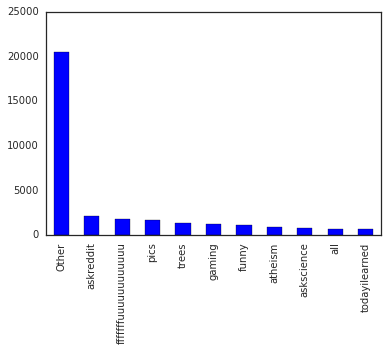

In [423]:
import numpy as np
#I had tried this with more than the top 10 (ie, top 50), but it didn't make much of a difference in the ROC.
#Also tried without this variable, and it hasn't hurt the ROC, though the improvement, if any, is small.
topSubreddits = np.array(redditDataset.Subreddit.value_counts()[0:10].axes[0])
revisedSubreddits = redditDataset.Subreddit

def inTop(x):
    words = str(x).split(" ")
    for x in words:
        if x in topSubreddits:
            return x #just take the first one mentioned...
    return "Other" #If none of the words match a top subreddit, assume that it's talking about something else

        
redditDataset.Subreddit = revisedSubreddits.apply(inTop)
redditDataset.Subreddit.value_counts().plot(kind='bar')

In [424]:
#DogCat

# The "I like turtles" selection is a clear reference to the meme, and so is a joking response. We should be able to lump the
# other minor responses in with this category as well as technically invalid or unknown.

In [425]:
#No harm in keeping the I like turtles value -- it's going to be replaced with a dummy variable anyway.
redditDataset.DogCat = redditDataset.DogCat.replace("none", "I like turtles.")
redditDataset.DogCat = redditDataset.DogCat.replace("askreddit", "I like turtles.")
redditDataset.DogCat = redditDataset.DogCat.replace("movies", "I like turtles.")

In [426]:
#Cheese
redditDataset[(redditDataset.Cheese=="none") |
              (redditDataset.Cheese==" awww") |
              (redditDataset.Cheese==" f7u12")]

,ID,Gender,Age,MaritalStatus,EmploymentStatus,Military,LWChildren,Education,Country,AnnIncome,Subreddit,DogCat,Cheese
0,1,Male,25-34,Single,Employed full time,No,No,Bachelor's degree,NorthAmerica,"$150,000 or more",Other,I like turtles.,none
1,2,Male,25-34,Blank,Employed full time,No,No,Bachelor's degree,NorthAmerica,"$150,000 or more",gaming,I like turtles.,none
2,3,Female,18-24,Blank,Freelance,No,No,Some college,NorthAmerica,"Under $20,000",Other,I like turtles.,none
3,4,Male,25-34,Blank,Freelance,No,No,Bachelor's degree,NorthAmerica,"$150,000 or more",Other,I like turtles.,none
4,5,Female,25-34,Blank,Employed full time,No,No,Bachelor's degree,NorthAmerica,"$70,000 - $99,999",Other,I like turtles.,none
5442,5443,Female,35-44,Married/civil union/domestic partnership,Student,No,No,Graduate or professional degree,NorthAmerica,"Under $20,000",Other,I like turtles.,awww
11169,11170,Male,18-24,In a relationship,Freelance,No,No,Bachelor's degree,NorthAmerica,"$50,000 - $69,999",Other,I like turtles.,f7u12
20154,20157,Female,18-24,In a relationship,Student,No,No,Some college,NorthAmerica,"Under $20,000",Other,I like turtles.,f7u12


Here it looks like we can lump the last three all into the "none" category, acting as an unknown.

In [427]:
redditDataset.Cheese = redditDataset.Cheese.replace(" awww", "none")
redditDataset.Cheese = redditDataset.Cheese.replace(" f7u12", "none")

### Post-exploration cleanup

In [428]:
redditDataset = redditDataset.drop(["ID"], axis=1) #This probably doesn't need to be dropped, but might as well.

### Transform Categorical Variables into Dummies

In [429]:
categoricalVariables = redditDataset.columns
for variable in categoricalVariables:
    redditDataset=pd.concat([redditDataset, pd.get_dummies(pd.DataFrame(redditDataset[variable], columns=[str(variable)]))], axis=1)
    redditDataset=redditDataset.drop([variable], axis=1)
    
#No need for deleting columns here since Random Forests aren't sensitive to collinearity.

### Graph correlation matrix

C:\Users\Izzy\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(....) is deprecated, use sort_index(.....)


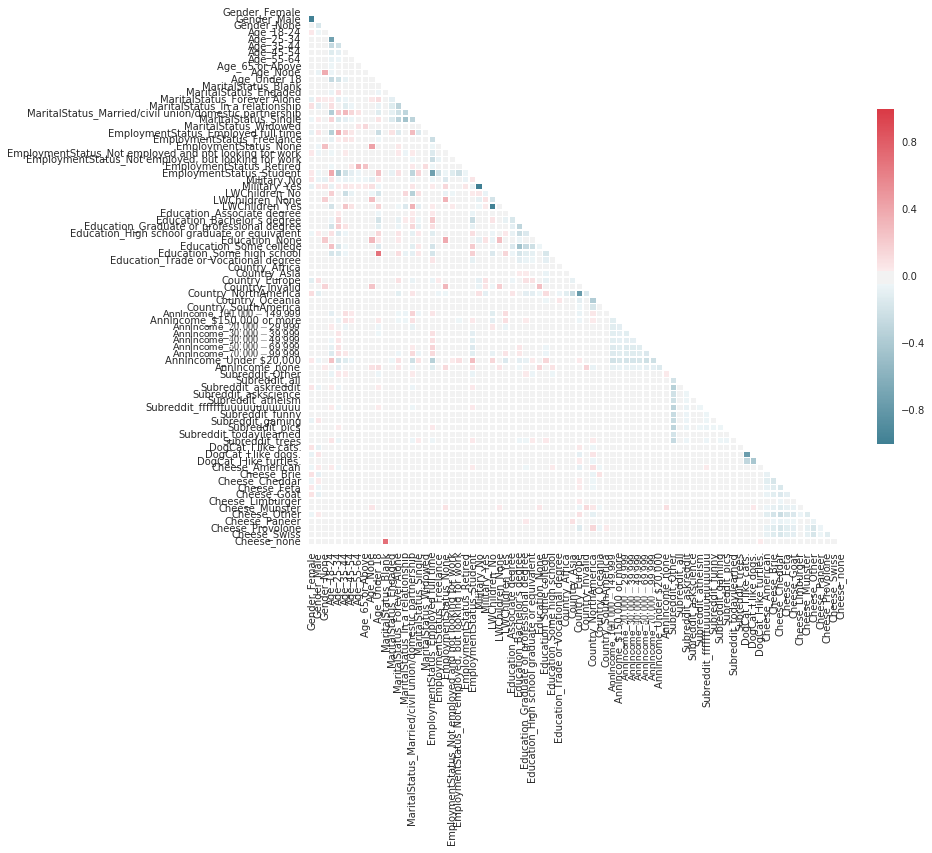

In [430]:
#Reference/Example Consulted: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = redditDataset.sort().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, #xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

We can see that the areas near the diagonal tend to have a bluish tinge, strongest in particular for those paired dummy variables that were not eliminated (since random forests can handle them). Also worth noting are the strong red freckle-like spots in the body of the graph. These look to be related to oddball/default answers like "None", which may indicate that a number of users were not interested in answering these questions or taking the questions seriously. Or it may indicate a bot -- we did find some SQL code for some of the answers, so it's already reasonable to suspect that a select few may have been interested in causing trouble with the survey itself. It's also not surprising that the Age<18 crowd has not yet completed a high school education.

### Build a Random Forest Model

In [431]:
X = redditDataset
y = X.pop("Military_Yes")
X.drop(["Military_No"], inplace=True, axis=1) #No cheating! :p

In [432]:
X.head()

,Gender_Female,Gender_Male,Gender_None,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 or Above,Age_None,...,Cheese_Cheddar,Cheese_Feta,Cheese_Goat,Cheese_Limburger,Cheese_Munster,Cheese_Other,Cheese_Paneer,Cheese_Provolone,Cheese_Swiss,Cheese_none
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [433]:
from sklearn.ensemble import RandomForestRegressor
militaryYesModel = RandomForestRegressor(n_estimators = 1000, oob_score=True, n_jobs=-1)
militaryYesModel.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [434]:
from sklearn.metrics import roc_auc_score
y_oob = militaryYesModel.oob_prediction_
print "ROC: ", roc_auc_score(y, y_oob)

ROC:  0.646440542685


In [435]:
##The following commented code is adapted directly from lecture entitled Random Forests == Awesome

#results = []
#n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

#for trees in n_estimator_options:
#    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
#    model.fit(X, y)
#    print trees, "trees"
#    roc = roc_auc_score(y, model.oob_prediction_)
#    print "C-stat: ", roc
#    results.append(roc)
#    print ""
#    
#pd.Series(results, n_estimator_options).plot();

In [436]:
##The following commented code is adapted directly from lecture entitled Random Forests == Awesome

#results = []
#max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

#for max_features in max_features_options:
#    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
#    model.fit(X, y)
#    print max_features, "option"
#    roc = roc_auc_score(y, model.oob_prediction_)
#    print "C-stat: ", roc
#    results.append(roc)
#    print ""
#  
#d.Series(results, max_features_options).plot(kind="barh", xlim=(.65,.67));

In [437]:
##The following commented code is adapted directly from lecture entitled Random Forests == Awesome

#results = []
#min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#
#for min_samples in min_samples_leaf_options:
#    model = RandomForestRegressor(n_estimators=1000, 
#                                 oob_score=True, 
#                                  n_jobs=-1, 
#                                  random_state=42, 
#                                  max_features="auto", 
#                                  min_samples_leaf=min_samples)
#    model.fit(X, y)
#    print min_samples, "min samples"
#    roc = roc_auc_score(y, model.oob_prediction_)
#    print "C-stat: ", roc
#    results.append(roc)
#    print ""
#    
#pd.Series(results, min_samples_leaf_options).plot();

### Final Model

In [438]:
from sklearn.ensemble import RandomForestRegressor
militaryYesModel = RandomForestRegressor(n_estimators = 2000, oob_score=True, n_jobs=-1, max_features=0.2, min_samples_leaf=13)
militaryYesModel.fit(X, y)
from sklearn.metrics import roc_auc_score, accuracy_score
y_oob = militaryYesModel.oob_prediction_
print "ROC: ", roc_auc_score(y, y_oob), "\n", "Acc: ", accuracy_score(y, y_oob.round())

ROC:  0.712898790258 
Acc:  0.933559280633


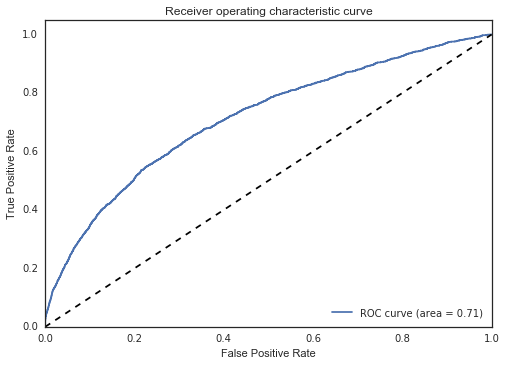

In [439]:
#The following ROC curve code is from the Week 6 lecture

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_oob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_oob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()